# Analysis of Bacteroides thetaiotaomicron VPI-5482 CarveMe model

## **ENSEMBLE** MODEL

In [1]:
from glob import glob
from framed import load_cbmodel
import pandas as pd
import numpy as np
from framed.io.sbml import sanitize_id

import reframed
from reframed.cobra.ensemble import load_ensemble

import cobra
from cobra.io import read_sbml_model

from scipy.spatial.distance import jaccard

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Reactions producing and consuming neuroactive metabolites in ENSEMBLE model

In [2]:
EnsembleModel=load_ensemble("LB_Btheta_gram_Ensemble_gapFilled_after.xml.gz")
EnsembleRxDict=EnsembleModel.reaction_states
# print(EnsembleRxDict)
EnsembleRxDF=pd.DataFrame.from_dict(EnsembleRxDict, orient='index')
EnsembleRxDF=EnsembleRxDF*1 #from bool values to binary values
# print(EnsembleRxDF)
EnsembleRxDF=EnsembleRxDF.rename(index=lambda s: str(s).replace('R_',''))
print(EnsembleRxDF.shape)
# print(EnsembleRxDF.index)
EnsembleNeuroRxsDF=EnsembleRxDF.copy()
print(EnsembleNeuroRxsDF.shape)
EnsembleNeuroRxsDF = EnsembleNeuroRxsDF.iloc[:,4:]
EnsembleNeuroRxsDF

(2671, 100)
(2671, 100)


,4,5,6,7,8,9,10,11,12,13,...,90,91,92,93,94,95,96,97,98,99
12DGR120tipp,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
12DGR140tipp,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
12DGR141tipp,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
12DGR160tipp,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12DGR161tipp,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EX_xylan4_e,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
EX_xylb_e,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
EX_zn2_e,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Growth,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [3]:
BinaryGramRxs=EnsembleNeuroRxsDF.copy()
BinaryGramRxs["number of models"] = BinaryGramRxs.sum(axis=1) 

BinaryGramRxs_sorted= BinaryGramRxs.sort_values(by=['number of models'])

BinaryGramRxs_sorted=BinaryGramRxs_sorted[(BinaryGramRxs_sorted['number of models'] != 0) & (BinaryGramRxs_sorted['number of models'] != len(BinaryGramRxs_sorted.iloc[:,:-1].columns))]

removing suboptimal solutions (by visualisation analysis of pattern):

In [4]:
diff=BinaryGramRxs_sorted.copy()
diff.sort_index(inplace=True)
strangeModels=EnsembleRxDF.copy()
strangeModels = strangeModels.iloc[:,0:4]
strangeModels = strangeModels[strangeModels.index.isin(diff.index)]
# strangeModels

In [5]:
strangeModelsZero=strangeModels.iloc[:,0].values.tolist()
diff.insert(0,'0','')
diff['0'] = strangeModelsZero
strangeModelsOne=strangeModels.iloc[:,1].values.tolist()
diff.insert(1,'1','')
diff['1'] = strangeModelsOne
strangeModelsTwo=strangeModels.iloc[:,2].values.tolist()
diff.insert(2,'2','')
diff['2'] = strangeModelsTwo
strangeModelsThree=strangeModels.iloc[:,3].values.tolist()
diff.insert(3,'3','')
diff['3'] = strangeModelsThree
# diff

In [6]:
diff=diff.drop(columns=['number of models'])

### add one column to ensemble dataframe with information from the model "LBmedium_Btheta_gram_gapFilled_after.xml.gz", so that we can compare

In [7]:
Gram_LB_gapAfter_Model=read_sbml_model("LBmedium_Btheta_gram_gapFilled_after.xml.gz")
Gram_LB_gapAfter_Model.optimize()

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


,fluxes,reduced_costs
12DGR120tipp,0.000000,0.000000e+00
12DGR140tipp,0.000000,0.000000e+00
12DGR141tipp,0.000000,0.000000e+00
12DGR160tipp,0.000000,0.000000e+00
12DGR161tipp,0.105544,0.000000e+00
...,...,...
Growth,1.403247,6.661338e-16
ATPM,0.000000,-3.082649e-02
G1PACT,0.132590,-6.938894e-18
H2SO,-9.993913,-0.000000e+00


In [8]:
ensembleDiffRxs=list(diff.index.values)
# ensembleDiffRxs

In [9]:
specificRxs=[]
for RxID in Gram_LB_gapAfter_Model.reactions:
    specificRxs.append(RxID.id)
print(len(specificRxs))

2154


In [10]:
InModelData=[]
OutModelData=[]
for ERx in ensembleDiffRxs:
    if ERx in specificRxs:
        InModelRow=[ERx, 1]
        InModelData.append(InModelRow)
    else:
        OutModelRow=[ERx, 0]
        OutModelData.append(OutModelRow)
        
InModelDF=pd.DataFrame(InModelData, columns=['reaction',  'presence'])
OutModelDF=pd.DataFrame(OutModelData, columns=['reaction',  'presence'])
oneModel_AllRXsDF = pd.concat([InModelDF, OutModelDF])
oneModel_AllRXsDF=oneModel_AllRXsDF.set_index('reaction')
# oneModel_AllRXsDF

In [55]:
diffModel=diff.copy()
diffModel.sort_index(inplace=True)
oneModel_AllRXsDF.sort_index(inplace=True)
oneModelValues=oneModel_AllRXsDF["presence"].values.tolist()
diffModel.insert(0,'gram_LB_gapAfter','')
diffModel['gram_LB_gapAfter'] = oneModelValues
diffModel["number of models"] = diffModel.sum(axis=1) 
diffModel= diffModel.sort_values(by=['number of models'])
# diffModel

In [56]:
NeuroactiveDF=pd.read_excel('allNeuroRxsIds.xlsx')
TransportersDF=pd.read_excel('transporters.xlsx')
ExchangesDF=pd.read_excel('exchanges.xlsx')


NeuroactiveIDs=NeuroactiveDF.ReactionID.unique()
TransportersIDs=TransportersDF.ReactionID.unique()
# print(len(TransportersIDs))
ExchangesIDs=ExchangesDF.ReactionID.unique()
# print(len(ExchangesDF))

RxTypes=[]
        
for index, rows in diffModel.iterrows():
    if index in NeuroactiveIDs:
        RxTypes.append("Neuro")
    elif index in TransportersIDs:
        RxTypes.append("Transp")
    elif index in ExchangesIDs:
        RxTypes.append("Ex")
    else:
        RxTypes.append(" ")

In [57]:
diffModel["ReactionType"]=RxTypes
diffModel.index = diffModel.index.map(str) + " " + diffModel["ReactionType"].map(str)
# diffModel=diffModel.drop(columns=['number of models', 'ReactionType'])
diffModel

,gram_LB_gapAfter,0,1,2,3,4,5,6,7,8,...,92,93,94,95,96,97,98,99,number of models,ReactionType
PTHPS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,12,
PTHPS_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,12,
3HAD40_2,0,0,0,1,0,0,0,0,0,1,...,0,0,1,1,1,0,0,1,30,
3OAR40_2,0,0,0,1,0,0,0,0,0,1,...,0,0,1,1,1,0,0,1,30,
3HAD40,1,1,0,1,1,0,0,0,1,1,...,1,1,1,1,0,1,1,0,59,
3OAR40,1,1,0,1,1,0,0,0,1,1,...,1,1,1,1,0,1,1,0,59,
3HACPH,1,1,0,1,1,0,0,0,1,1,...,1,1,1,1,1,1,1,1,73,
3HOXTPP,1,1,0,1,1,0,0,0,1,1,...,1,1,1,1,1,1,1,1,73,
3SALATAi Neuro,1,1,1,1,0,1,1,1,1,1,...,0,1,0,1,0,0,1,0,81,Neuro
ASPA2 Neuro,1,1,1,1,0,1,1,1,1,1,...,0,1,0,1,0,0,1,0,81,Neuro


In [37]:
gramModelRxs=diffModel.copy()
gramModelRxs=gramModelRxs[gramModelRxs['gram_LB_gapAfter'] == 1]
gramModelRxs=gramModelRxs.T
gramModelRxs["number of reactions"] = gramModelRxs.sum(axis=1) 
gramModelRxs=gramModelRxs[gramModelRxs['number of reactions'] == 10]
gramModelRxs=gramModelRxs.T
print(len(gramModelRxs.columns)-1, 'models have the same reactions as the specified model')
# gramModelRxs

39 models have the same reactions as the specified model


In [54]:
diffModelRxsCount=diffModel.copy()
diffModelRxsCount=diffModelRxsCount.T
diffModelRxsCount["number of reactions"] = diffModelRxsCount.sum(axis=1) 
diffModelRxsCount= diffModelRxsCount.sort_values(by=['number of reactions'],ascending=False)
diffModelRxsCount.drop(columns=['number of reactions'], inplace=True)
modelIndex=diffModelRxsCount.index.get_loc('gram_LB_gapAfter')
gramVals=diffModelRxsCount.iloc[modelIndex,].values.tolist()
diffModelRxsCount.drop(index=('gram_LB_gapAfter'), inplace=True)
diffModelRxsCount=diffModelRxsCount.reset_index(drop=True)
diffModelRxsCount=diffModelRxsCount.T
diffModelRxsCount.insert(modelIndex,'gram_LB_gapAfter','')
diffModelRxsCount['gram_LB_gapAfter'] = gramVals
diffModelRxsCount

,PTHPS,PTHPS_1,3HAD40_2,3OAR40_2,3HAD40,3OAR40,3HACPH,3HOXTPP,3SALATAi Neuro,ASPA2 Neuro,SEAHCYSHYD,SEAHCYSHYD_1,GLBRAN2,GLDBRAN2,number of reactions
21,1,1,1,1,1,1,1,1,1,1,1,1,1,1,14
14,1,1,1,1,1,1,1,1,1,1,1,1,1,1,14
79,1,1,1,1,1,1,1,1,1,1,1,1,1,1,14
8,0,0,1,1,1,1,1,1,1,1,1,1,1,1,12
24,0,0,1,1,1,1,1,1,1,1,1,1,1,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,0,0,0,0,0,0,0,0,0,0,1,1,1,1,4
5,0,0,0,0,0,0,0,0,1,1,0,0,1,1,4
35,0,0,0,0,0,0,0,0,1,1,1,1,0,0,4
55,0,0,0,0,0,0,0,0,1,1,0,0,1,1,4


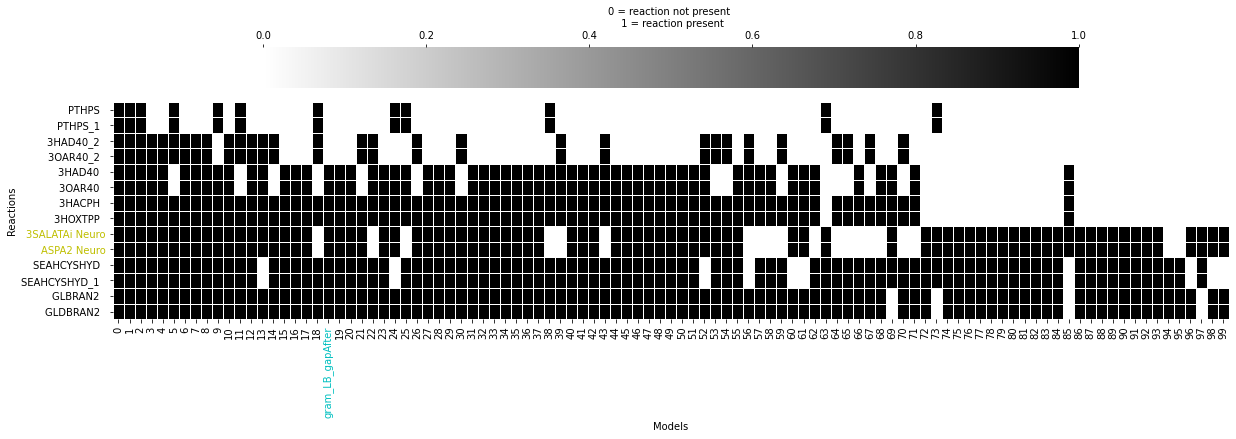

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (20,5))

s=sns.heatmap(diffModelRxsCount, cmap=plt.get_cmap('binary'), xticklabels=True, yticklabels=True, cbar_kws={'label': '0 = reaction not present \n 1 = reaction present', 'location': 'top'}, linewidth=0.5)
s.set(xlabel='Models', ylabel='Reactions')

for l in s.xaxis.get_ticklabels()+s.yaxis.get_ticklabels():
    if 'Transp' in l.get_text():
        l.set_color('m')
    elif 'Ex' in l.get_text():
        l.set_color('b')
    elif 'Neuro' in l.get_text():
        l.set_color('y')
    elif 'gram' in l.get_text():
        l.set_color('c')


# plt.savefig('Ensemble_allRxs_Differences.pdf', format="pdf",bbox_inches="tight")
# plt.savefig('Ensemble_allRxs_Diff_sorted.png',bbox_inches="tight")